# Installations

In [28]:
%pip install beautifulsoup4 --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install langgraph

  Using cached msgpack-1.1.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.4 kB)
Using cached msgpack-1.1.0-cp311-cp311-macosx_11_0_arm64.whl (81 kB)
Note: you may need to restart the kernel to use updated packages.


# **Agent for analyzing 10-K and 10-Q**

In [5]:
import os, getpass, requests
from datetime import datetime
import pandas as pd
from bs4 import BeautifulSoup
from typing import Dict, List, Tuple, Any
from typing_extensions import TypedDict
from IPython.display import Image, display, Markdown
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

headers = {'User-Agent' : "robdallagogar@gmail.com"}

- in place vector db, rag pipeline. 

- scrawl for ai

## Prompts

In [6]:
# System Prompt for 10-K Report Summarization
PROMPT_10K = """You are a financial expert working as an AI trading agent. Your task is to summarize the provided 10-K report, focusing on information crucial for making informed investment decisions.

Instructions:

1.  **Concise Summary:** Provide a summary of the 10-K report in 500 words or less.
2.  **Investment Focus:** Prioritize information relevant to investors, including:
    *   **Financial Performance:** Highlight key metrics like revenue, net income, earnings per share, and profitability trends.
    *   **Growth Prospects:** Discuss the company's growth strategy, market opportunities, and potential for future expansion.
    *   **Risk Factors:** Identify and summarize significant risks that could negatively impact the company's business and stock performance.
    *   **Management's Outlook:** Summarize management's discussion and analysis of the company's financial condition, results of operations, and future outlook.
3.  **Target Audience:** Write the summary as if you are explaining it to a sophisticated AI trading agent that needs to understand the company's financial health and potential for investment. 

provided 10-K report:
{extracted_10k}


Please provide the summary below: """

#System Prompt for 10-Q Report Summarization:
PROMPT_10Q = """You are a financial analyst working as an AI trading agent. Your job is to extract key investment insights from the given 10-Q report.

Instructions:

1.  **Concise and Targeted:**  Provide a brief summary of the 10-Q report, focusing specifically on information pertinent to short-term trading decisions.
2.  **Key Metrics:** Extract and clearly present the company's revenue, net income, and earnings per share for the reported quarter.
3.  **Performance Trends:** Analyze the reported figures in the context of previous quarters to identify any significant changes or trends in financial performance. 
4.  **Management's Commentary:** Summarize the management's discussion of the company's recent performance and any insights into future prospects.
5.  **Stock Impact:**  Highlight any information or events discussed in the report that could have a near-term impact on the company's stock price. 

provided 10-Q report:
{extracted_10q}


Please present your analysis below:"""


CONCLUSION_PROMPT = """
    You are a seasoned financial advisor working as an AI trading agent. You speacialize in making informed investment decisions based on a comprehensive understanding of company fundamentals. You have been provided with summarized 10-K and 10-Q reports for analysis.

    10-K Summary:
    {summary_10k}

    10-Q Summary:
    {summary_10q}

    Instructions:

    1.  **Company Assessment:** Based on the provided summaries, assess the overall financial health and investment potential of the company.
    2.  **Key Factors:** Consider the following factors in your evaluation:
        *   **Financial Performance:** Analyze revenue trends, profitability, earnings quality, and cash flow generation.
        *   **Growth Prospects:** Evaluate the company's growth strategy, market position, competitive landscape, and potential for future expansion.
        *   **Risk Assessment:**  Identify and analyze significant risks that could impact the company's financial performance and future prospects. Consider factors such as industry trends, economic conditions, competition, regulatory changes, and the company's specific risk profile.
        *   **Management Quality:** Assess the company's management team, their track record, strategic decision-making, and ability to navigate challenges.
        *   **Valuation:**  Consider the company's current valuation relative to its financial performance, growth prospects, and industry peers.
    3.  **FINMEM Alignment:** Your analysis should align with FINMEM's objectives as a trading agent. Focus on identifying companies with strong financial fundamentals, sustainable growth potential, manageable risks, and attractive valuations.
    4.  **Quantitative Insights:** When possible, extract and present relevant financial metrics from the summaries to support your qualitative analysis. Examples include:
        *   Revenue growth rates
        *   Profit margins
        *   Return on equity
        *   Debt-to-equity ratio
        *   Earnings per share 
    5.  **Investment Recommendation:**  Based on your comprehensive assessment, provide a clear and concise investment recommendation for FINMEM.  Choose from:
        *   **Strong Buy:** The company exhibits exceptional financial health, robust growth potential, and an attractive valuation.
        *   **Buy:** The company demonstrates solid fundamentals, promising growth prospects, and a reasonable valuation.
        *   **Hold:** The company's performance is mixed, with balanced risks and opportunities.  
        *   **Sell:** The company faces significant challenges or risks that outweigh its potential.
        *   **Strong Sell:** The company's financial health is severely compromised, and its future prospects are dim. 
    6.  **Reasoning:** Clearly explain the reasoning behind your investment recommendation.  Support your conclusion with evidence from the summarized reports and your analysis of the key factors outlined above.

    Present your analysis and recommendation below in a structured and concise manner.
    """

## Helper functions

In [7]:
def disp(text):
    return display(Markdown(text))

def download_10KQ_report(ticker: str, cik: str, accession_number: str, report: str):
    """
    Downloads all available .htm and .txt files related to a specific 10-K report for a given company.
    
    This function takes a stock ticker symbol, a CIK (Central Index Key), and an accession number,
    and downloads each document associated with the 10-K report (typically in .htm or .txt format).
    The files are saved in a unique directory named with the ticker, a description (10K_REPORTS),
    and a timestamp, providing an organized structure for multiple report downloads.

    Parameters:
    - ticker (str): The stock ticker symbol of the company (e.g., "AAPL" for Apple).
    - cik (str): The Central Index Key, a unique identifier for companies in SEC filings.
    - accession_number (str): The accession number of the specific 10-K filing, without hyphens.
    - headers (dict): Dictionary of headers for the SEC API request (must include User-Agent).

    Returns:
    - str: The path to the folder where the 10-K files were saved.
    """
    
    # Generate folder name with ticker and timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"{ticker}_{report}_REPORTS_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    # Get the document URL for the 10-K / 10-Q metadata
    document_url = f"https://www.sec.gov/Archives/edgar/data/{cik}/{accession_number}/index.json"
    
    # Fetch the document metadata
    doc_response = requests.get(document_url, headers=headers)
    if doc_response.status_code == 200:
        doc_data = doc_response.json()
        
        # Loop through all files in the filing and download .htm or .txt files
        for file in doc_data['directory']['item']:
            if report in file['name'].lower() and (file['name'].endswith('.htm') or file['name'].endswith('.txt')):
                file_url = f"https://www.sec.gov/Archives/edgar/data/{cik}/{accession_number}/{file['name']}"
                print(f"Downloading file: {file_url}")
                
                # Download the 10-K / 10-Q document
                file_content = requests.get(file_url, headers=headers).content
                
                # Save the 10-K / 10-Q document to the designated folder
                output_path = os.path.join(output_dir, file['name'])
                with open(output_path, 'wb') as f:
                    f.write(file_content)
                print(f"Saved {report} report to {output_path}")
    else:
        print("Failed to retrieve document metadata.")
    
    # Return the folder path where the files are saved
    output_dir = output_dir + '/'
    return output_dir


def parse_first_file_in_folder(folder_path: str):
    """
    Reads the first .htm or .txt file in a specified folder and parses its content into a string.
    
    This function is designed to find the first file (alphabetically by filename) in a folder and 
    return its content as a text string. If the file is in HTML format, the function uses BeautifulSoup
    to parse and extract plain text. For .txt files, it reads and returns the content directly.

    Parameters:
      folder_path (str): The path to the folder containing the downloaded 10-K files.

    Returns:
      str: The parsed content of the first file in the folder.
    """
    
    # List all files in the folder and sort them to ensure the first one is picked
    files = sorted(os.listdir(folder_path)) # Sorting did work putting it in the right format! 
    files = [files[0]] # CHANGE THIS LATER
    for file_name in files:
        if file_name.endswith('.htm') or file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            print(f"Reading file: {file_name}")
            
            # Read the content of the file
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                
                # If it's an HTML file, parse it and extract text
                if file_name.endswith('.htm'):
                    soup = BeautifulSoup(content, 'html.parser')
                    return soup.get_text(separator='\n')
                
                # If it's a .txt file, return the content directly
                return content

    #If no .htm or .txt file is found, return an empty string or error message
    print("No .htm or .txt files found in the folder.")
    return ""

## Graph State

In [8]:
# Graph state:
class GraphState10KQ(MessagesState):
    ticker: str
    trading_personality: str # JUST A NOTE FOR LATER INCLUSION

    # States internal to the graph:
    cik: str
    extracted_10k: str # TO BE DECIDED
    summary_10k: str
    extracted_10q: str # TO BE DECIDED
    summary_10q: str
    reports_conclusion: str # insights and conclusions about the company

## Nodes and Edges

In [9]:
# NODES
def extract_cik(state: GraphState10KQ):
    """
    Extracts the Central Index Key (CIK) for a given stock ticker symbol from SEC's company tickers database.
    
    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'NVDA')
        
    Returns:
        str: The 10-digit CIK number padded with leading zeros
        
    The function:
    1. Makes a request to SEC's company tickers JSON endpoint
    2. Creates a DataFrame with company information
    3. Pads CIK numbers with leading zeros to 10 digits
    4. Filters for the requested ticker
    5. Returns the corresponding CIK
    """
    ticker = state['ticker']
    # Make request to SEC api endpoint
    companyTickers = requests.get("https://www.sec.gov/files/company_tickers.json",headers = headers)
    # Save Company name and ticker mapping in a dataframe
    companyData = pd.DataFrame.from_dict(companyTickers.json(), orient = 'index')
    # Add leading zeros to cki_str to make get requests to the submission endepoint
    companyData['cik_str'] = companyData['cik_str'].astype(str).str.zfill(10)
    # Filter only ticker data
    tickerData = companyData[companyData['ticker'] == ticker]
    cik = tickerData['cik_str'].item()
    print("This is the cik: ", cik, " for ticker: ", ticker)
    # {"messages": [llm_with_tools.invoke(state["messages"])]}
    return { "messages": state["messages"],"cik" : cik}


def extract_10k(state: GraphState10KQ):
    
    ticker = state['ticker']
    cik = state['cik']
    # get company specific filing metadata
    filingMetadata = requests.get(f'https://data.sec.gov/submissions/CIK{cik}.json', headers = headers)
    # Save only relevant columns in a dataframe: 'accessionNumber', 'reportDate', 'form'
    allForms = pd.DataFrame.from_dict(filingMetadata.json()['filings']['recent'])[['accessionNumber', 'reportDate', 'form']]
    # Filter out 10k most recent 10-K report
    latest_10k  = allForms[allForms['form'] == '10-K' ].iloc[0]
    # Obtain acession_number 
    accession_number = latest_10k['accessionNumber'].replace("-", "")

    # Store 10-K in a local directory
    output_dir = download_10KQ_report(ticker, cik, accession_number, report = '10-k')

    # Parse 10-K (as of now only parsing a piece of it)
    extracted_10k = parse_first_file_in_folder(output_dir)

    return {"messages": state["messages"], "extracted_10k" : extracted_10k}

def summarize_10k(state: GraphState10KQ):
    shorter_10k = state["extracted_10k"][: len(state["extracted_10k"]) // 2]
    prompt = PROMPT_10K.format(extracted_10k = shorter_10k)
    response = llm.invoke(prompt)
    summary_10k = response.content
    return {"messages": state["messages"], "summary_10k" : summary_10k}

def extract_10q(state: GraphState10KQ):
    ticker = state['ticker']
    cik = state['cik']
    # get company specific filing metadata
    filingMetadata = requests.get(f'https://data.sec.gov/submissions/CIK{cik}.json', headers = headers)
    # Save only relevant columns in a dataframe: 'accessionNumber', 'reportDate', 'form'
    allForms = pd.DataFrame.from_dict(filingMetadata.json()['filings']['recent'])[['accessionNumber', 'reportDate', 'form']]
    
    # Filter out 10-Q most recent 10-K report
    latest_10q  = allForms[allForms['form'] == '10-Q' ].iloc[0]
    # Obtain acession_number 
    accession_number = latest_10q['accessionNumber'].replace("-", "")

    # Store 10-Q in a local directory
    output_dir = download_10KQ_report(ticker, cik, accession_number, report = '10-q')

    # Parse 10-Q (as of now only parsing a piece of it)
    extracted_10q = parse_first_file_in_folder(output_dir)

    return {"messages": state["messages"], "extracted_10q" : extracted_10q}

def summarize_10q(state: GraphState10KQ):
    prompt = PROMPT_10Q.format(extracted_10q = state["extracted_10q"])
    response = llm.invoke(prompt)
    summary_10q = response.content
    return {"messages": state["messages"], "summary_10q": summary_10q}

def draw_conclusion(state: GraphState10KQ):
    prompt = CONCLUSION_PROMPT.format(summary_10k = state["summary_10k"], summary_10q =  state["summary_10q"])
    response = llm.invoke(prompt)
    reports_conclusion = response.content
    return {"messages": state["messages"], "reports_conclusion" : reports_conclusion}


## Build the Graph

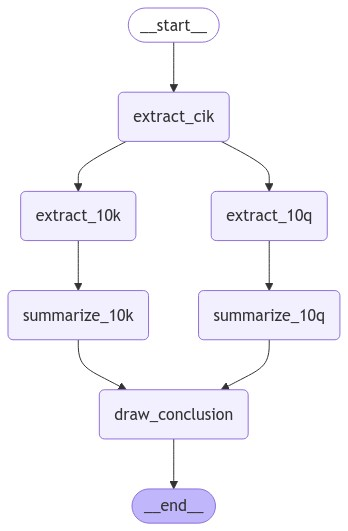

In [10]:
# Add nodes and edges  
builder = StateGraph(GraphState10KQ)
builder.add_node("extract_cik", extract_cik)
builder.add_node("extract_10k", extract_10k)
builder.add_node("summarize_10k", summarize_10k)
builder.add_node("extract_10q", extract_10q)
builder.add_node("summarize_10q", summarize_10q)
builder.add_node("draw_conclusion", draw_conclusion)

# Add edges using string identifiers
builder.add_edge(START, "extract_cik")
builder.add_edge("extract_cik", "extract_10k")
builder.add_edge("extract_cik", "extract_10q")
# edge to summarize 10k
builder.add_edge("extract_10k", "summarize_10k")
# edge to summarize 10q
builder.add_edge("extract_10q", "summarize_10q")
# edges to draw conclusion
builder.add_edge("summarize_10k", "draw_conclusion")
builder.add_edge("summarize_10q", "draw_conclusion")
builder.add_edge("draw_conclusion", END)

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## **Run Graph**

In [11]:
thread = {"configurable": {"thread_id": "1"}}
# Run the graph until the first interruption
events = []
for event in graph.stream({"ticker":'AAPL'}, thread, stream_mode="values"):
    events.append(event)
    print("EVENT: ", event)

EVENT:  {'messages': [], 'ticker': 'AAPL'}
This is the cik:  0000320193  for ticker:  AAPL
EVENT:  {'messages': [], 'ticker': 'AAPL', 'cik': '0000320193'}
Saved 10-q report to AAPL_10-q_REPORTS_20241111_092318/a10-qexhibit31106292024.htm
Saved 10-q report to AAPL_10-q_REPORTS_20241111_092318/a10-qexhibit31206292024.htm
Saved 10-q report to AAPL_10-q_REPORTS_20241111_092318/a10-qexhibit32106292024.htm
Reading file: a10-qexhibit31106292024.htm
Saved 10-k report to AAPL_10-k_REPORTS_20241111_092318/a10-kexhibit10199282024.htm
Saved 10-k report to AAPL_10-k_REPORTS_20241111_092318/a10-kexhibit10209282024.htm
Saved 10-k report to AAPL_10-k_REPORTS_20241111_092318/a10-kexhibit10219282024.htm
Saved 10-k report to AAPL_10-k_REPORTS_20241111_092318/a10-kexhibit10229282024.htm
Saved 10-k report to AAPL_10-k_REPORTS_20241111_092318/a10-kexhibit1919282024.htm
Saved 10-k report to AAPL_10-k_REPORTS_20241111_092318/a10-kexhibit21109282024.htm
Saved 10-k report to AAPL_10-k_REPORTS_20241111_092318/a1

In [12]:
final_state = graph.get_state(thread)
disp(final_state.values['reports_conclusion'])

### Company Assessment of Apple Inc.

#### 1. Financial Performance
Apple Inc. has demonstrated strong financial health, as evidenced by its fiscal year 10-K report and the Q2 2024 10-Q report. Key metrics include:
- **Revenue:** $394.3 billion for the fiscal year, with a year-over-year growth of 8%. Q2 2024 revenue of $81.4 billion reflects a 5% increase from Q1 2024.
- **Net Income:** $99.8 billion for the fiscal year, with a net income of $19.9 billion in Q2 2024, showing a 3% increase from the previous quarter.
- **Earnings Per Share (EPS):** EPS of $6.10 for the fiscal year and $1.24 in Q2 2024, indicating improved profitability.

The gross margin of 42.5% and operating income of $108.5 billion highlight effective cost management and strong profitability. The company also maintains a healthy cash reserve of $27 billion, providing flexibility for strategic investments and shareholder returns.

#### 2. Growth Prospects
Apple's growth strategy is centered on expanding its services ecosystem, which is increasingly contributing to total revenue. The company is investing in augmented reality (AR) and artificial intelligence (AI), positioning itself to capture emerging market opportunities. The focus on health and fitness technology also indicates potential for future growth. Management's optimism regarding upcoming product launches, particularly in the iPhone and services sectors, further supports the company's growth narrative.

#### 3. Risk Assessment
While Apple Inc. has a strong market position, several risks could impact its performance:
- **Supply Chain Disruptions:** Geopolitical tensions and global supply chain challenges could affect product availability and costs.
- **Regulatory Scrutiny:** Increased scrutiny regarding antitrust issues and data privacy could lead to legal challenges.
- **Market Competition:** Intense competition from companies like Samsung and emerging tech firms poses a risk to market share.
- **Economic Conditions:** Macroeconomic factors, including inflation and changes in consumer spending, could adversely affect sales.

#### 4. Management Quality
Apple's management team has a strong track record of innovation and strategic decision-making. Their commitment to maintaining a strong balance sheet and focus on customer satisfaction are positive indicators of their ability to navigate challenges. The management's proactive approach to expanding services and enhancing customer engagement is commendable.

#### 5. Valuation
Apple's current valuation appears reasonable given its strong financial performance and growth prospects. The company's ability to generate consistent revenue and profit growth, coupled with its strategic investments in high-growth areas, positions it favorably compared to industry peers.

#### 6. Investment Recommendation
**Recommendation: Buy**

#### Reasoning
Apple Inc. exhibits solid fundamentals, promising growth prospects, and a reasonable valuation. The company's strong financial performance, characterized by robust revenue growth, healthy profit margins, and effective cost management, supports this recommendation. Additionally, the proactive management strategy focused on innovation and expanding the services ecosystem enhances its growth potential.

While there are risks associated with supply chain disruptions, regulatory scrutiny, and market competition, the overall outlook remains positive. The anticipated product launches and management's optimistic guidance for future quarters further bolster the investment case.

In conclusion, Apple Inc. represents a compelling investment opportunity, making it suitable for a "Buy" recommendation.